# Facial Recognition with Local Binary Patterns (LBP)

### LBPs are constructed by dividing the face to be recognized into a grid of cells (classically 7x7, here 8x8).  For each cell, a Local Binary Pattern histogram is constructed. LBPs calculate a local representation of texture. This  is performed by comparing each pixel with its surrounding neighborhood of pixel values.  The resulting histograms are concatenated with weights.  More weight is given to the cells near the eyes and less weight is given to the cells outside the cheeks.

### This code uses the Caltech Faces dataset.  The details of the data loading are done in the utility load_caltech_faces.  The following code is largely a port of PyImageSearch to Jupyter.  Because PyImageSearch code uses CV2 extensively and because cv2.imshow() does not play nice with Jupyter, the image display functionality is ported to matplotlib.

#### This notebook contains five steps
1. First the data is loaded and separated into training and testing datasets
2. A random set of training images are shown
3. The LBPH Face Recognizer is initialized and fit (trained)
4. The LBPH model is evaluated 
5. A sample of the predicted faces are presented

##### Import required libraries

In [1]:
%matplotlib inline
from loader import load_caltech_faces
from resultsmontage import ResultsMontage
from plot import plotArray
from plot import plotArray1Row
import imutils
import cv2
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report


from skimage import exposure
from skimage.color import rgb2lab, rgb2gray, lab2rgb
from skimage.io import imread, imshow

import matplotlib.pyplot as plt
import numpy as np
import random

##### Set some constants, most of these control the size of the local binary patterns

In [22]:
trace = False
sample_size = 12
LBradius=2 
LBneighbors=16
LBgridx=8
LBgridy=8

##### Get the data.  This implementation is on Windows, so the path requires escaped backspaces

##### load_caltech_faces performs the following functions:
* Load the image and convert it to grayscale
* Grab the bounding box associated with the current image, 
* Extract the face ROI, and resize it to a canonical size
* If the flatten flag is set, flatten to a vector - LBP does not require flattened data
* Append the canonical sized face to a data matrix
* Convert the data matrix to a NumPy array
* Associate the data labels with the correct faces
* Check to see that the minimum number of faces are present
* Shuffle the data
* Split the data into testing and training
* Return Training, Testing and Labels

In [16]:
ctf = 'C:\\Working\\PyImage\\faces\\caltech_faces'
(training, testing, names) = load_caltech_faces(ctf, min_faces=21, test_size=0.25)

#cv2 wants integers for the target so use Label Encoder to make the conversion
le = LabelEncoder()
le.fit_transform(training.target);

### Examine the training data

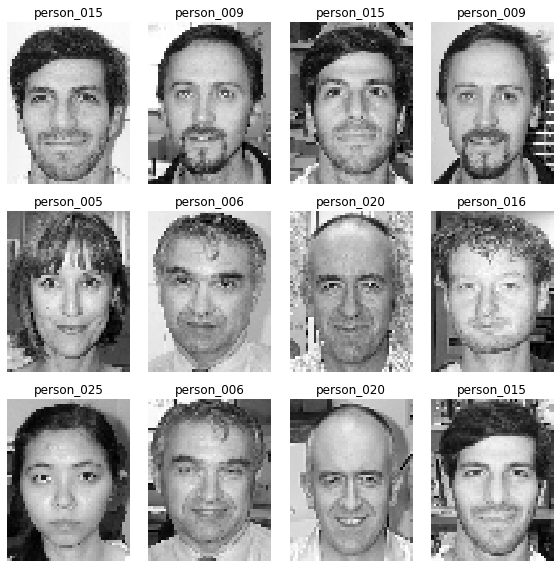

In [3]:
sample_view = []
sample_img = []
sample_tit = []
for i in range(12):
    sample_view.append(random.randint(0,len(training.target)))
for i in range(len(sample_view)):
    sample_img.append(training.data[sample_view[i]].reshape((62, 47)).astype("uint8"))
    sample_tit.append(training.target[sample_view[i]])
plotArray(sample_img, sample_tit, 3,4,(8,8),font=12)

#### Instantiate and train the LBP  Classifier

In [4]:
recognizer = cv2.face.LBPHFaceRecognizer_create(radius=LBradius,neighbors=LBneighbors,grid_x=LBgridx,grid_y=LBgridy)

print("[INFO] training face recognizer...")
recognizer.train(training.data, le.transform(training.target))

[INFO] training face recognizer...


#### Evaluate the Classifier
* Classifier is k-NN with k = 1 and a chi-squared distance metric
* Confidence is the chi-squared distance between the input and predicted LBP histograms.
* Lower is better.

In [19]:
predictions = []
confidence = []
for i in range(0, len(testing.data)):
    if trace: print("{} of {}".format(str(i), str(len(testing.data))))
        
    # classify the face and update the list of predictions and confidence scores
    (prediction, conf) = recognizer.predict(testing.data[i])
    predictions.append(prediction)
    confidence.append(conf)
 
# show the classification report
print(classification_report(le.transform(testing.target), predictions,target_names=np.unique(names)))

              precision    recall  f1-score   support

  person_001       1.00      1.00      1.00         7
  person_004       1.00      1.00      1.00         6
  person_005       1.00      1.00      1.00         4
  person_006       1.00      1.00      1.00         7
  person_009       1.00      1.00      1.00         5
  person_014       1.00      1.00      1.00         4
  person_015       1.00      1.00      1.00         3
  person_016       1.00      1.00      1.00         7
  person_020       1.00      1.00      1.00         3
  person_023       1.00      1.00      1.00         6
  person_025       1.00      1.00      1.00         6
  person_026       1.00      1.00      1.00         5

    accuracy                           1.00        63
   macro avg       1.00      1.00      1.00        63
weighted avg       1.00      1.00      1.00        63



##### Examine some of the predictions

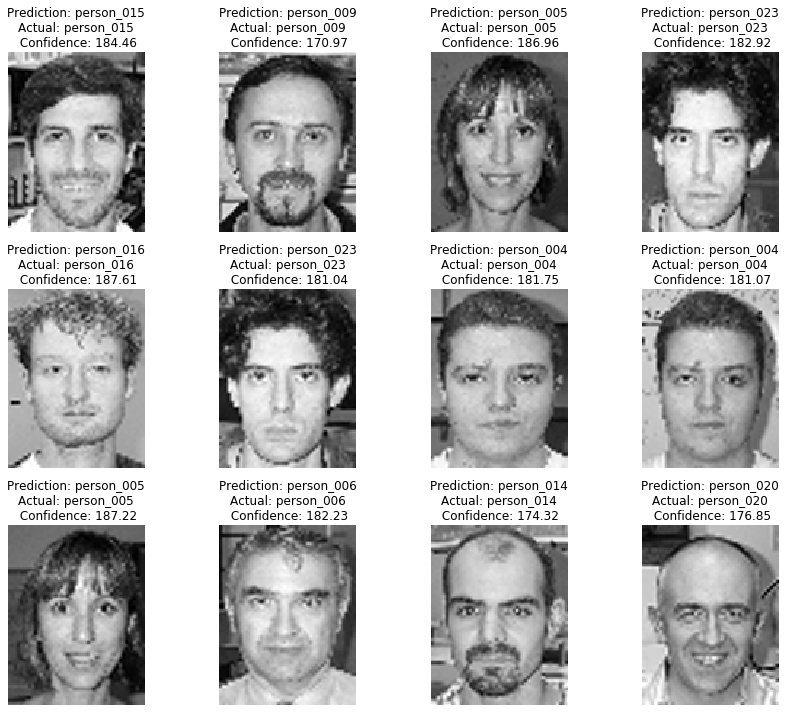

In [15]:
images = []
titles = []
sample_size = 12

for i in np.random.randint(0, high=len(testing.data), size=sample_size):   #i is the number of the face to get
    # grab the face and classify it
    face = testing.data[i]
    images.append(imutils.resize(face, width=face.shape[1] * 2, inter=cv2.INTER_CUBIC))
    
    pred_name = le.inverse_transform([predictions[i]])[0]
    face_name = testing.target[i]
           
    titles.append("Prediction: "+ pred_name +"\nActual: "+ face_name+"\n Confidence: "+f'{confidence[i]:.2f}')
    
plotArray(images, titles, 3,4,(12,10),font=12)  